In [1]:
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/opt/anaconda3/envs/micronsbinder/lib/python3.7/site-packages/python_jsonschema_objects/__init__.py:53: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  self.schema["$schema"]


In [2]:
# setup the mesh meta to handle downloads and caching
mesh_dir = '../meshes'
seg_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v185/seg"
mm = trimesh_io.MeshMeta(cv_path=seg_source,
                         disk_cache_path='mesh_dir', 
                         cache_size=20)



In [3]:
# pick your favorite segid from neuroglancer, you can copy paste
# IDs by right clicking on segmentation layer
# right hand panel shows selectedIDs with copy buttons
seg_id = 648518346349538235


In [4]:
# this will download the mesh via cloudvolume 
# and convert it to a Mesh object (an extension of trimesh)
# https://github.com/mikedh/trimesh
# see MeshParty docs https://meshparty.readthedocs.io/en/latest/?badge=latest
# for more information
mesh = mm.mesh(seg_id=seg_id, remove_duplicate_vertices=True)

In [5]:
# mesh has 2.1 million vertices, and 4.1 million triangular faces
mesh.n_vertices, mesh.n_faces

(1448352, 2895512)

In [6]:
# read in the synapses betwee  excitatory cell bodies in volume
soma_subgraph_df = pd.read_csv('../soma_subgraph_synapses_spines_v185.csv')

In [7]:
# filter the synapses onto this cell
cell_subgraph = soma_subgraph_df.query(f'post_root_id=={seg_id}')
# make an array of xyz synapse positions
syn_xyz=cell_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values

(TrackedArray(304642.6875), TrackedArray(144633.40625))

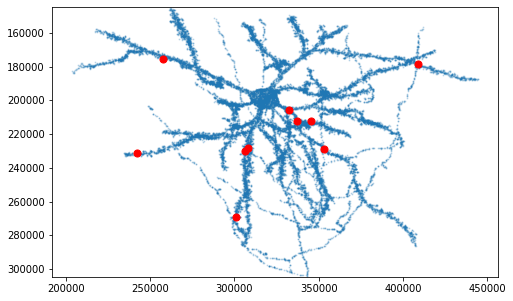

In [8]:
# let's make a simple 2d visualization of the 
f,ax = plt.subplots(figsize=(8,8))
ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,1], s=1, alpha=.2)
# add in the locations of synapses between cell bodies

ax.scatter(syn_xyz[:,0], syn_xyz[:,1], c='r', s=50)
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))


In [9]:
# find the closest mesh point indices to these synapses
# returns distance and index
# makes use of kdtree on mesh vertices to speed lookup
syn_ds, syn_mesh_inds=mesh.kdtree.query(syn_xyz)

In [10]:
# all the distances are quite close < 110 nm
# mesh vertices have ~150 nm spacing
syn_ds, syn_mesh_inds

(array([19.27634282, 69.44647263, 51.6071754 , 59.55694368, 29.38253545,
        63.28300007, 93.31838674, 58.17857646, 47.32863826, 50.31157332]),
 array([1117961,  323425,  438223,  827034,  888615,   44148,   71018,
        1004216, 1424790,  393730]))

In [11]:
# import scipy's spare graph library
from scipy import sparse


In [12]:
# now we can use graph algorithms to calculate shortest paths on the mesh
# this for example finds all the distances from the first synaspe
# along with a data structure that leaves pointers about
# how to get back to the that index
ds, path = sparse.csgraph.dijkstra(mesh.csgraph,
                             directed=False,
                             return_predecessors=True,
                             indices=syn_mesh_inds[0])

In [13]:
# convert the predecessors into a path from synapse 1 to synapse 0
syn_to_syn_path = utils.get_path(syn_mesh_inds[0], syn_mesh_inds[1], path)

(TrackedArray(304642.6875), TrackedArray(144633.40625))

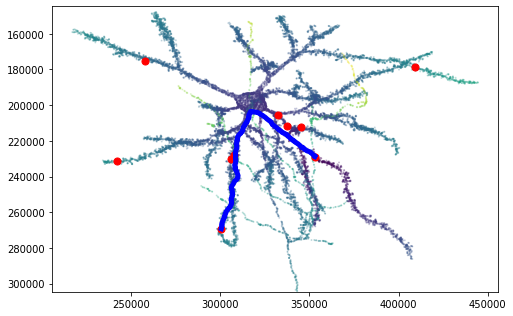

In [14]:
# let's make a simple 2d visualization of thes results
f,ax = plt.subplots(figsize=(8,8))

# now we will color the mesh vertices by how far they are from the synpase
ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,1], c=ds[::50], s=1, alpha=.2)

# let plot the path between the synapses
ax.plot(mesh.vertices[syn_to_syn_path,0], mesh.vertices[syn_to_syn_path,1], 'b', linewidth=5)
# and plot the synapse locations again
ax.scatter(syn_xyz[:,0], syn_xyz[:,1], c='r', s=50)
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))


A word of caution that sometimes a neuron contacts itself, such as when it's axon touches it's own dendrite.  
Also there are gaps in the meshes when missing data caused a break in the segmentation that was fixed by proofreading.

In such cases the mesh topology does not reflect the real topology of cell membranes.
The meshes in the tar file on the website are better in this respect but are only for the cells with cell bodies in the volume.

If you unpack the tar file and set the disk_cache_directory to that directory, the MeshMeta will read those meshes instead of downloading new files.

These mesh files are not used in the Binder example as it would make the image too large.

In [16]:
# it's more fun to visualize things in 3d though...
# neuroglancer is great, but its more difficult to control
# exactly what you want to visualize
# such as only components of mesh, or colorings
# see MeshParty documentation for more options in this area

In [25]:
from itkwidgets import view

# need to convert path to a set of edges
edges = utils.paths_to_edges([syn_to_syn_path])
# create a set of vertices and edges for path
sk_verts, sk_edges = trimesh_vtk.remove_unused_verts(mesh.vertices,
                                                     edges)
# create a vtk polydata from this
sk_poly = trimesh_vtk.graph_to_vtk(sk_verts, sk_edges)
# step 1

# convert cell mesh to vtkpolydata as well
poly_data = trimesh_vtk.trimesh_to_vtk(mesh.vertices, mesh.faces, None)

# step 2
# then create a viewer with this view function
# pass in polydata objects, what colors you want
# see docstring for more options
viewer=view(geometries=[poly_data, sk_poly],
            geometry_colors=['g','b'], 
            geometry_opacities=[.2, 1.0],
            ui_collapsed=True)


In [26]:
viewer

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…